In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import gdown
import zipfile
import random
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
import string
import numpy as np

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Data Preparation

Hyper parameters

In [2]:
# Define root directory
root_dir = '/tmp/tea'

# Define paths
SOURCE_DIR = "/tmp/dataset/"
TRAINING_DIR = "/tmp/tea/training/"
VALIDATION_DIR = "/tmp/tea/validation/"

# Define proportion of images used for training
split_size = .85

# Define input shape details
input_height = 224
input_width = 224
num_channels = 3

## Import data from Google Drive

### Import from Downloadable Drive

In [3]:
# import online

# Google Drive URL
url = 'https://drive.google.com/uc?id=1NWEJE9d0fbwe_eKBIE788w9RgUTmYgeo'
# Destination to save the file
output = './cnn_dataset.zip'

# Download the file
gdown.download(url, output, quiet=False)

# Unzip the file to a local directory
local_zip = output
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/tmp/dataset')

Downloading...
From (original): https://drive.google.com/uc?id=1NWEJE9d0fbwe_eKBIE788w9RgUTmYgeo
From (redirected): https://drive.google.com/uc?id=1NWEJE9d0fbwe_eKBIE788w9RgUTmYgeo&confirm=t&uuid=e0d64c26-f54e-4de8-897f-33102cf72091
To: /content/cnn_dataset.zip
100%|██████████| 395M/395M [00:04<00:00, 92.8MB/s]


### Import from Local Google Drive

In [ ]:
# read csv data file
# from google.colab import drive
# drive.mount('/content/drive')

# path = "/content/drive/MyDrive/Colab Notebooks/CNN-Capstone-Dataset/dataset.zip"
# zip_ref   = zipfile.ZipFile(path, 'r')
# zip_ref.extractall('/tmp/dataset')
# zip_ref.close()

In [ ]:
# show all exported label
print(os.listdir('/tmp/dataset'))

['nu_tea', 'teh_kotak_lemon', 'fruit_tea_strawberry', 'fres_tea', 'teh_botol_kotak', 'teh_kotak_ori', 'teh_botol_botol', 'teh_pucuk']


In [ ]:
shutil.rmtree('/tmp')

## Directory Creation

In [4]:
# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path, classes):
    train_dir = os.path.join(root_path, 'training')
    val_dir = os.path.join(root_path, 'validation')

    # Make directories for each class in training and validation sets
    for class_name in classes:
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)

        os.makedirs(train_class_dir)
        os.makedirs(val_class_dir)

try:
    classes = os.listdir('/tmp/dataset')
    create_train_val_dirs(root_path=root_dir, classes=classes)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/tea/training
/tmp/tea/validation
/tmp/tea/training/kaleng_soda_limeapel_greensands
/tmp/tea/training/plastik_mie_kariayam_indomie
/tmp/tea/training/plastik_biskuit_classic_goodtime
/tmp/tea/training/kaleng_susu_ori_beruang
/tmp/tea/training/botol_teh_less_tehpucuk
/tmp/tea/training/botol_yogurt_ori_cimory
/tmp/tea/training/kaca_nrg_ori_kratingdeng
/tmp/tea/training/kotak_susu_fullcream_ultramilk
/tmp/tea/training/cup_mie_goreng_sedaap
/tmp/tea/training/botol_kopi_aren_kopken
/tmp/tea/training/botol_soda_ori_tebs
/tmp/tea/training/kaleng_soda_strawberry_fanta
/tmp/tea/training/plastik_mie_sotomie_indomie
/tmp/tea/training/botol_teh_ori_tehgelas
/tmp/tea/training/plastik_mie_sotospesial_indomie
/tmp/tea/training/kotak_jus_jambu_abc
/tmp/tea/training/kotak_jus_jerukperasless_nutrisaari
/tmp/tea/training/plastik_coklat_susu_dairymilk
/tmp/tea/training/botol_teh_blackcurrant_fruittea
/tmp/tea/training/plastik_mie_goreng_sedaap
/tmp/tea/training/botol_kopi_cappuccino_golda
/tmp/tea/trai

## Data Splitting

In [5]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  # List all files in the source directory
  files = os.listdir(SOURCE_DIR)

  # Print messages about zero-length images
  for file in files:
    if os.path.getsize(os.path.join(SOURCE_DIR, file)) == 0:
      print(f"{file} is zero length, so ignoring.")

  # Remove zero-sized images
  files = [file for file in files if os.path.getsize(os.path.join(SOURCE_DIR, file)) > 0]

  # Calculate the split size
  split_count = len(files) - int(len(files) * SPLIT_SIZE)
  split_index = len(files)//split_count

  # Split the files into training and validation sets
  training_files = []
  validation_files = []

  for i in range(len(files)):
    if (i%split_index) == 0:
      validation_files.append(files[i])
    else:
      training_files.append(files[i])

  # training_files = files[split_count:]
  # validation_files = files[:split_count]

  # Copy training files to the training directory
  for file in training_files:
    source_file = os.path.join(SOURCE_DIR, file)
    destination_file = os.path.join(TRAINING_DIR, file)
    shutil.copyfile(source_file, destination_file)

  # Copy validation files to the validation directory
  for file in validation_files:
    source_file = os.path.join(SOURCE_DIR, file)
    destination_file = os.path.join(VALIDATION_DIR, file)
    shutil.copyfile(source_file, destination_file)

In [6]:
# Make directories for each class in training and validation sets
classes_native = os.listdir(SOURCE_DIR)

for class_name in classes_native:
    TRAINING_CLASS_DIR = os.path.join(TRAINING_DIR, class_name)
    VALIDATION_CLASS_DIR = os.path.join(VALIDATION_DIR, class_name)

    # Empty directories in case you run this cell multiple times
    if len(os.listdir(TRAINING_CLASS_DIR)) > 0:
      for file in os.scandir(TRAINING_CLASS_DIR):
        os.remove(file.path)
    if len(os.listdir(VALIDATION_CLASS_DIR)) > 0:
      for file in os.scandir(VALIDATION_CLASS_DIR):
        os.remove(file.path)

# Run the function
# NOTE: Messages about zero length images should be printed out
for i in range(len(classes_native)):
    TRAINING_CLASS_DIR = os.path.join(TRAINING_DIR, classes[i])
    VALIDATION_CLASS_DIR = os.path.join(VALIDATION_DIR, classes[i])

    SOURCE_CLASS_DIR = os.path.join(SOURCE_DIR, classes_native[i])
    split_data(SOURCE_CLASS_DIR,
               TRAINING_CLASS_DIR,
               VALIDATION_CLASS_DIR,
               split_size)

In [7]:
# Your function should perform copies rather than moving images so original directories should contain unchanged images
for i in range(len(classes_native)):
    TRAINING_CLASS_DIR = os.path.join(TRAINING_DIR, classes[i])
    VALIDATION_CLASS_DIR = os.path.join(VALIDATION_DIR, classes[i])
    SOURCE_CLASS_DIR = os.path.join(SOURCE_DIR, classes_native[i])

    print(f"Original {classes[i]}'s directory has {len(os.listdir(SOURCE_CLASS_DIR))} images")

    # Training and validation splits. Check that the number of images matches the expected output.
    print(f"There are {len(os.listdir(TRAINING_CLASS_DIR))} images of {classes[i]} for training")
    print(f"There are {len(os.listdir(VALIDATION_CLASS_DIR))} images of {classes[i]} for validation")

    print(f"\n")

Original kaleng_soda_limeapel_greensands's directory has 200 images
There are 166 images of kaleng_soda_limeapel_greensands for training
There are 34 images of kaleng_soda_limeapel_greensands for validation


Original plastik_mie_kariayam_indomie's directory has 200 images
There are 166 images of plastik_mie_kariayam_indomie for training
There are 34 images of plastik_mie_kariayam_indomie for validation


Original plastik_biskuit_classic_goodtime's directory has 200 images
There are 166 images of plastik_biskuit_classic_goodtime for training
There are 34 images of plastik_biskuit_classic_goodtime for validation


Original kaleng_susu_ori_beruang's directory has 200 images
There are 166 images of kaleng_susu_ori_beruang for training
There are 34 images of kaleng_susu_ori_beruang for validation


Original botol_teh_less_tehpucuk's directory has 200 images
There are 166 images of botol_teh_less_tehpucuk for training
There are 34 images of botol_teh_less_tehpucuk for validation


Original 

## Data Augmentation Handling

### with Image Augmentation

In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Training datagen
  train_datagen = ImageDataGenerator(rescale=(1./255),
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.3,
                                     brightness_range=[0.05, 0.3],
                                     fill_mode='nearest')

  # Training generator
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=100,
      class_mode='sparse',
      target_size=(input_height, input_width))

  # ==================================================

  # Validation datagen
  validation_datagen = ImageDataGenerator(rescale=(1./255))

  # Validation generator
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=100,
      class_mode='sparse',
      target_size=(input_height, input_width))

  return train_generator, validation_generator

### no Image Augmentation

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Training datagen
  train_datagen = ImageDataGenerator(rescale=(1./255))

  # Training generator
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=20,
      class_mode='sparse',
      target_size=(input_height, input_width))

  # ==================================================

  # Validation datagen
  validation_datagen = ImageDataGenerator(rescale=(1./255))

  # Validation generator
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=20,
      class_mode='sparse',
      target_size=(input_height, input_width))

  return train_generator, validation_generator

### rest of the code...

In [9]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 8964 images belonging to 54 classes.
Found 1836 images belonging to 54 classes.


In [10]:
x_batch_train, y_batch_train = next(train_generator)
print(x_batch_train.shape)  # Should be (batch_size, height, width, channels)
print(y_batch_train.shape)  # Should be (batch_size, num_classes)

(100, 224, 224, 3)
(100,)


In [11]:
x_batch_val, y_batch_val = next(validation_generator)
print(x_batch_val.shape)  # Should be (batch_size, height, width, channels)
print(y_batch_val.shape)  # Should be (batch_size, num_classes)

(100, 224, 224, 3)
(100,)


In [12]:
# Check the class indices to see the order of the labels
print("Class indices:", train_generator.class_indices)
print("Classes:", train_generator.classes)

# Similarly for validation generator
print("Validation Class indices:", validation_generator.class_indices)
print("Validation Classes:", validation_generator.classes)

Class indices: {'botol_elektrolit_ori_pocari': 0, 'botol_kopi_aren_kopken': 1, 'botol_kopi_cappuccino_golda': 2, 'botol_kopi_susu_abc': 3, 'botol_soda_jeruk_fanta': 4, 'botol_soda_ori_cocacola': 5, 'botol_soda_ori_tebs': 6, 'botol_soda_strawberry_fanta': 7, 'botol_soda_zerosugar_cocacola': 8, 'botol_teh_apel_frestea': 9, 'botol_teh_blackcurrant_fruittea': 10, 'botol_teh_less_sosro': 11, 'botol_teh_less_tehpucuk': 12, 'botol_teh_ori_sosro': 13, 'botol_teh_ori_tehgelas': 14, 'botol_yogurt_mixedfruit_cimory': 15, 'botol_yogurt_ori_cimory': 16, 'cup_mie_ayam_popmie': 17, 'cup_mie_ayambawang_popmie': 18, 'cup_mie_goreng_sedaap': 19, 'cup_mie_kariayam_popmie': 20, 'cup_mie_sotoayam_popmie': 21, 'kaca_nrg_ori_kratingdeng': 22, 'kaleng_soda_limeapel_greensands': 23, 'kaleng_soda_ori_cocacola': 24, 'kaleng_soda_ori_sprite': 25, 'kaleng_soda_sodawater_polaris': 26, 'kaleng_soda_strawberry_fanta': 27, 'kaleng_susu_ori_beruang': 28, 'kotak_jus_apel_abc': 29, 'kotak_jus_jambu_abc': 30, 'kotak_jus_j

# Data Processing

## Model Creation

In [21]:
def baseLayers(inputs):
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 2, activation = 'relu', padding='same')(inputs)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)


  x = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 2, activation = 'relu', padding='same')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)


  x = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 2, activation = 'relu', padding='same')(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(x)


  x = tf.keras.layers.BatchNormalization()(x)
  return x

In [22]:
def basicModel(inputs, num_classes):
  x = baseLayers(inputs)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)

  # x_b = baseLayers(tf.image.rgb_to_grayscale(inputs))
  # x_b = tf.keras.layers.Dropout(0.6)(x_b)
  # x_b = tf.keras.layers.Flatten()(x_b)

  # x = tf.keras.layers.Concatenate()([x_a, x_b])
  # x = tf.keras.layers.Activation('relu')(x)

  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  return Model(inputs=inputs, outputs=x)

## Model Training

In [23]:
# myCNN = CNNPalingPerkasa(num_classes=len(classes_native))
# myCNN = MobileNet(num_classes=len(classes_native))
myCNN = basicModel(tf.keras.layers.Input(shape=(input_height, input_width, num_channels)),
                  num_classes=len(classes_native))

In [24]:
myCNN.build(input_shape=(None, input_height, input_width, num_channels))

In [25]:
myCNN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 128)         7385

In [26]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') > 0.94 and logs.get('val_accuracy') > 0.94):
                self.model.stop_training = True

callback = MyCallback()

In [27]:
myCNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = myCNN.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    callbacks=[callback],
                    validation_data=validation_generator)

Epoch 1/50
90/90 [==============================] - 143s 2s/step - loss: 3.0628 - accuracy: 0.1865 - val_loss: 3.2385 - val_accuracy: 0.2217
Epoch 2/50
90/90 [==============================] - 137s 2s/step - loss: 1.4649 - accuracy: 0.5364 - val_loss: 2.3230 - val_accuracy: 0.4455
Epoch 3/50
90/90 [==============================] - 138s 2s/step - loss: 0.8898 - accuracy: 0.7067 - val_loss: 1.3235 - val_accuracy: 0.6972
Epoch 4/50
90/90 [==============================] - 140s 2s/step - loss: 0.6637 - accuracy: 0.7777 - val_loss: 0.7950 - val_accuracy: 0.7908
Epoch 5/50
90/90 [==============================] - 138s 2s/step - loss: 0.5169 - accuracy: 0.8207 - val_loss: 0.4920 - val_accuracy: 0.8290
Epoch 6/50
90/90 [==============================] - 137s 2s/step - loss: 0.4642 - accuracy: 0.8408 - val_loss: 0.3662 - val_accuracy: 0.8715
Epoch 7/50
90/90 [==============================] - 143s 2s/step - loss: 0.4254 - accuracy: 0.8537 - val_loss: 0.3884 - val_accuracy: 0.8818
Epoch 8/50
90

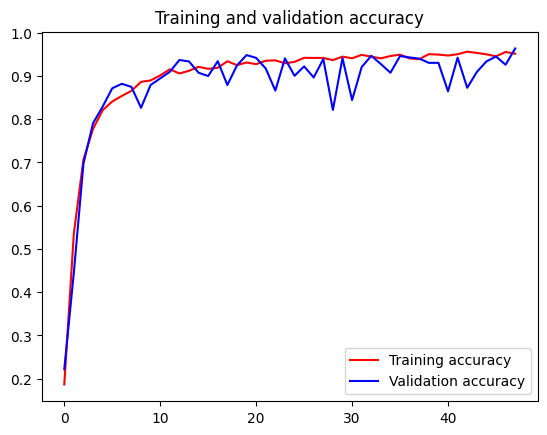

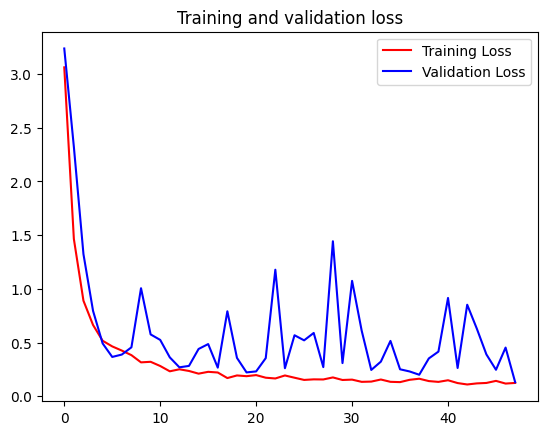

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model Testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Load the image
new_image = plt.imread('/content/drive/MyDrive/Colab Notebooks/CNN-Capstone-Dataset/nu.jpg')

# Ensure the image has the correct number of channels (e.g., 3 for RGB)
if new_image.shape[-1] != 3:
    new_image = tf.image.grayscale_to_rgb(new_image)

# Resize the image to the input shape required by your model
input_shape = (input_height, input_width)  # Replace with your model's input shape
new_image = tf.image.resize(new_image, input_shape)

# Normalize the image (if your model was trained on normalized images, e.g., values in range [0, 1])
new_image = new_image / 255.0

# Add a batch dimension
new_image = np.expand_dims(new_image, axis=0)

# Make predictions
predictions = myCNN.predict(new_image)

# Print the predictions
print("Predictions:", predictions)

# Print the predicted label
predicted_label = np.argmax(predictions, axis=1)
print("Predicted label:", predicted_label)

print(list(train_generator.class_indices)[np.argmax(predictions)])

1/1 [==============================] - 0s 99ms/step
Predictions: [[4.8344651e-01 2.3278465e-06 4.5160946e-01 4.8102374e-04 8.0546663e-08
  1.2651273e-06 6.0666144e-02 3.7932382e-03]]
Predicted label: [0]
fres_tea


## Model Export

In [29]:
myCNN.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
